What this notebook does (baseline, not transfer yet):

Train a GRU4Rec model on MARS train using target vocab (702).

Evaluate on MARS val + test using Recall@20, MRR@20 (same protocol as 06/07).

Save metrics + best checkpoint.

In [1]:
# Quick (unsafe) workaround to avoid the libiomp5md.dll crash.
# Use this only to continue working in the notebook quickly.
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
print("Set KMP_DUPLICATE_LIB_OK=TRUE — restart kernel and re-run cells now.")

Set KMP_DUPLICATE_LIB_OK=TRUE — restart kernel and re-run cells now.


Imports & header

In [2]:
# CELL [08-01] — Imports & header

import json
from pathlib import Path
from typing import List, Dict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import IterableDataset, DataLoader

print("[08-01] Starting 08_gru4rec_baseline.ipynb")
print("[08-01] torch:", torch.__version__)


[08-01] Starting 08_gru4rec_baseline.ipynb
[08-01] torch: 2.5.1


Paths, device, load metadata

In [3]:
# CELL [08-02] — Paths & metadata

DATA_DIR = Path("../data/processed")
SHARDS_DIR = DATA_DIR / "tensor_shards_v2"
META_PATH = SHARDS_DIR / "metadata.json"
RESULTS_DIR = Path("../results")
RESULTS_DIR.mkdir(exist_ok=True)

assert META_PATH.exists(), f"[08-02] Missing: {META_PATH}"

with open(META_PATH, "r") as f:
    meta = json.load(f)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

MAX_PREFIX_LEN = meta["max_prefix_len"]
PAD_ID = meta["pad_id"]
UNK_ID = meta["unk_id"]
TARGET_VOCAB_SIZE = meta["vocab"]["target"]["size"]

print("[08-02] SHARDS_DIR:", SHARDS_DIR.resolve())
print("[08-02] DEVICE:", DEVICE)
print("[08-02] MAX_PREFIX_LEN:", MAX_PREFIX_LEN)
print("[08-02] TARGET_VOCAB_SIZE:", TARGET_VOCAB_SIZE)


[08-02] SHARDS_DIR: D:\00_DS-ML-Workspace\session-transfer-mooc\data\processed\tensor_shards_v2
[08-02] DEVICE: cuda
[08-02] MAX_PREFIX_LEN: 20
[08-02] TARGET_VOCAB_SIZE: 702


Loader utilities (self-contained, same as 07/06)

In [4]:
# CELL [08-03] — Loader utilities (self-contained)

def list_shards(domain: str, split: str) -> List[Path]:
    pattern = f"{domain}_{split}_shard_*.pt"
    files = sorted(SHARDS_DIR.glob(pattern))
    return files

class ShardExamplesDataset(IterableDataset):
    def __init__(self, shard_paths: List[Path]):
        super().__init__()
        self.shard_paths = list(shard_paths)

    def __iter__(self):
        for sp in self.shard_paths:
            shard = torch.load(sp, map_location="cpu", weights_only=True)
            n = shard["input_ids"].shape[0]
            for i in range(n):
                yield {
                    "input_ids": shard["input_ids"][i],
                    "attention_mask": shard["attention_mask"][i],
                    "pos_ids": shard["pos_ids"][i],
                    "labels": shard["labels"][i],
                    "lengths": shard["lengths"][i],
                }

def collate_batch(batch: List[Dict[str, torch.Tensor]]) -> Dict[str, torch.Tensor]:
    return {
        "input_ids": torch.stack([x["input_ids"] for x in batch], dim=0),
        "attention_mask": torch.stack([x["attention_mask"] for x in batch], dim=0),
        "pos_ids": torch.stack([x["pos_ids"] for x in batch], dim=0),
        "labels": torch.stack([x["labels"] for x in batch], dim=0),
        "lengths": torch.stack([x["lengths"] for x in batch], dim=0),
    }

def make_loader(domain: str, split: str, batch_size: int) -> DataLoader:
    shard_paths = list_shards(domain, split)
    assert len(shard_paths) > 0, f"[08-03] No shards found for {domain}/{split}"
    ds = ShardExamplesDataset(shard_paths)
    dl = DataLoader(ds, batch_size=batch_size, num_workers=0, collate_fn=collate_batch, drop_last=False)
    print(f"[08-03] Loader ready: {domain}/{split}, shards={len(shard_paths)}, batch_size={batch_size}")
    return dl


Metrics (Recall@20, MRR@20)

In [5]:
# CELL [08-04] — Metrics

@torch.no_grad()
def recall_at_k(scores: torch.Tensor, labels: torch.Tensor, k: int) -> float:
    topk = torch.topk(scores, k=k, dim=1).indices  # [B,k]
    hit = (topk == labels.unsqueeze(1)).any(dim=1).float()
    return float(hit.mean().item())

@torch.no_grad()
def mrr_at_k(scores: torch.Tensor, labels: torch.Tensor, k: int) -> float:
    topk = torch.topk(scores, k=k, dim=1).indices
    match = (topk == labels.unsqueeze(1))
    ranks = torch.arange(1, k + 1, device=scores.device).unsqueeze(0)  # [1,k]
    rr = torch.where(match, 1.0 / ranks, torch.zeros_like(ranks, dtype=torch.float))
    return float(rr.max(dim=1).values.mean().item())


Convert left-padded → right-padded (for GRU packing)

The tensors are left-padded. GRU packing is easiest with right padding.

In [6]:
# CELL [08-05] — Left-pad -> Right-pad conversion

def leftpad_to_rightpad(input_ids: torch.Tensor, lengths: torch.Tensor, pad_id: int) -> torch.Tensor:
    """
    input_ids: [B, T] left-padded
    lengths:   [B] number of real tokens
    returns:   [B, T] right-padded, preserving token order
    """
    B, T = input_ids.shape
    out = torch.full_like(input_ids, fill_value=pad_id)
    for i in range(B):
        L = int(lengths[i].item())
        if L <= 0:
            continue
        seq = input_ids[i, T - L:T]           # take last L tokens
        out[i, 0:L] = seq                      # place at beginning
    return out


GRU4Rec model (simple, strong baseline)

In [7]:
# CELL [08-06] — GRU4Rec model

class GRU4Rec(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int = 64, hidden_dim: int = 128, num_layers: int = 1, dropout: float = 0.0, pad_id: int = 0):
        super().__init__()
        self.pad_id = pad_id
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_id)
        self.gru = nn.GRU(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input_ids: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
        """
        input_ids: [B,T] right-padded
        lengths: [B]
        returns logits: [B,V]
        """
        emb = self.embedding(input_ids)  # [B,T,E]

        # pack (lengths must be on CPU for pack in some setups)
        lengths_cpu = lengths.detach().cpu()
        packed = nn.utils.rnn.pack_padded_sequence(emb, lengths_cpu, batch_first=True, enforce_sorted=False)
        packed_out, h_n = self.gru(packed)

        # last layer hidden state: [B,H]
        last_h = h_n[-1]
        logits = self.out(last_h)
        return logits


Training config

In [8]:
# CELL [08-07] — Training config

CFG = {
    "embed_dim": 64,
    "hidden_dim": 128,
    "num_layers": 1,
    "dropout": 0.0,
    "lr": 1e-3,
    "weight_decay": 0.0,
    "batch_size": 256,
    "epochs": 10,
    "eval_k": 20,
    "early_stop_patience": 3,
}

print("[08-07] CFG:", CFG)


[08-07] CFG: {'embed_dim': 64, 'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.001, 'weight_decay': 0.0, 'batch_size': 256, 'epochs': 10, 'eval_k': 20, 'early_stop_patience': 3}


Build loaders (MARS train/val/test)

In [9]:
# CELL [08-08] — Loaders

train_loader = make_loader("mars", "train", batch_size=CFG["batch_size"])
val_loader   = make_loader("mars", "val",   batch_size=CFG["batch_size"])
test_loader  = make_loader("mars", "test",  batch_size=CFG["batch_size"])


[08-03] Loader ready: mars/train, shards=1, batch_size=256
[08-03] Loader ready: mars/val, shards=1, batch_size=256
[08-03] Loader ready: mars/test, shards=1, batch_size=256


Train/eval steps

In [10]:
# CELL [08-09] — Train / Eval steps

def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0
    n_batches = 0

    for bi, batch in enumerate(loader, 1):
        input_ids = batch["input_ids"].to(device)
        lengths   = batch["lengths"].to(device)
        labels    = batch["labels"].to(device)

        # convert to right-padded for packing
        input_rp = leftpad_to_rightpad(input_ids, lengths, PAD_ID)

        logits = model(input_rp, lengths)
        loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        total_loss += float(loss.item())
        n_batches += 1

        if bi % 20 == 0:
            print(f"[08-09][TRAIN] batch={bi} loss={loss.item():.4f}")

    return total_loss / max(n_batches, 1)

@torch.no_grad()
def eval_model(model, loader, k: int, device):
    model.eval()
    recalls = []
    mrrs = []
    total = 0

    for bi, batch in enumerate(loader, 1):
        input_ids = batch["input_ids"].to(device)
        lengths   = batch["lengths"].to(device)
        labels    = batch["labels"].to(device)

        input_rp = leftpad_to_rightpad(input_ids, lengths, PAD_ID)
        logits = model(input_rp, lengths)

        recalls.append(recall_at_k(logits, labels, k))
        mrrs.append(mrr_at_k(logits, labels, k))
        total += labels.size(0)

        if bi % 20 == 0:
            print(f"[08-09][EVAL] batch={bi} running_total={total}")

    return {
        f"Recall@{k}": sum(recalls) / max(len(recalls), 1),
        f"MRR@{k}": sum(mrrs) / max(len(mrrs), 1),
        "num_examples": total
    }


Train loop with early stopping (by MRR@20)

In [ ]:
# CELL [08-10] — Train loop + early stopping

model = GRU4Rec(
    vocab_size=TARGET_VOCAB_SIZE,
    embed_dim=CFG["embed_dim"],
    hidden_dim=CFG["hidden_dim"],
    num_layers=CFG["num_layers"],
    dropout=CFG["dropout"],
    pad_id=PAD_ID
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"])

best_val_mrr = -1.0
best_state = None
patience = 0

for epoch in range(1, CFG["epochs"] + 1):
    print(f"\n[08-10] Epoch {epoch}/{CFG['epochs']}")

    train_loss = train_one_epoch(model, train_loader, optimizer, DEVICE)
    val_metrics = eval_model(model, val_loader, k=CFG["eval_k"], device=DEVICE)

    print(f"[08-10] train_loss={train_loss:.4f} | val={val_metrics}")

    val_mrr = val_metrics[f"MRR@{CFG['eval_k']}"]
    if val_mrr > best_val_mrr:
        best_val_mrr = val_mrr
        best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
        patience = 0
        print(f"[08-10] New best val MRR@{CFG['eval_k']}: {best_val_mrr:.6f}")
    else:
        patience += 1
        print(f"[08-10] No improvement. patience={patience}/{CFG['early_stop_patience']}")
        if patience >= CFG["early_stop_patience"]:
            print("[08-10] Early stopping triggered.")
            break




[08-10] Epoch 1/10
[08-10] train_loss=6.5416 | val={'Recall@20': 0.11658653989434242, 'MRR@20': 0.039107260294258595, 'num_examples': 282}
[08-10] New best val MRR@20: 0.039107

[08-10] Epoch 2/10
[08-10] train_loss=6.4120 | val={'Recall@20': 0.3218149095773697, 'MRR@20': 0.1921365186572075, 'num_examples': 282}
[08-10] New best val MRR@20: 0.192137

[08-10] Epoch 3/10
[08-10] train_loss=6.2901 | val={'Recall@20': 0.4244290888309479, 'MRR@20': 0.28055112063884735, 'num_examples': 282}
[08-10] New best val MRR@20: 0.280551

[08-10] Epoch 4/10
[08-10] train_loss=6.1566 | val={'Recall@20': 0.486328125, 'MRR@20': 0.31066174805164337, 'num_examples': 282}
[08-10] New best val MRR@20: 0.310662

[08-10] Epoch 5/10
[08-10] train_loss=6.0012 | val={'Recall@20': 0.494140625, 'MRR@20': 0.34603433310985565, 'num_examples': 282}
[08-10] New best val MRR@20: 0.346034

[08-10] Epoch 6/10
[08-10] train_loss=5.8101 | val={'Recall@20': 0.5635516941547394, 'MRR@20': 0.33783748745918274, 'num_examples': 

Load best checkpoint + evaluate on test

In [12]:
# CELL [08-11] — Evaluate best checkpoint on VAL + TEST

assert best_state is not None, "[08-11] best_state is None — training did not run properly"

model.load_state_dict(best_state)

best_val = eval_model(model, val_loader, k=CFG["eval_k"], device=DEVICE)
best_test = eval_model(model, test_loader, k=CFG["eval_k"], device=DEVICE)

print("[08-11] Best GRU4Rec VAL:", best_val)
print("[08-11] Best GRU4Rec TEST:", best_test)


[08-11] Best GRU4Rec VAL: {'Recall@20': 0.5987079441547394, 'MRR@20': 0.36282894015312195, 'num_examples': 282}
[08-11] Best GRU4Rec TEST: {'Recall@20': 0.6253063976764679, 'MRR@20': 0.43054597079753876, 'num_examples': 358}


Save metrics + model checkpoint

In [13]:
# CELL [08-12] — Save outputs

out = {
    "model": "GRU4Rec",
    "dataset": "mars",
    "config": CFG,
    "best_val": best_val,
    "best_test": best_test,
}

metrics_path = RESULTS_DIR / "gru4rec_mars_baseline.json"
ckpt_path = RESULTS_DIR / "gru4rec_mars_baseline.pt"

with open(metrics_path, "w") as f:
    json.dump(out, f, indent=2)

torch.save(best_state, ckpt_path)

print("[08-12] Saved metrics:", metrics_path.resolve())
print("[08-12] Saved checkpoint:", ckpt_path.resolve())


[08-12] Saved metrics: D:\00_DS-ML-Workspace\session-transfer-mooc\results\gru4rec_mars_baseline.json
[08-12] Saved checkpoint: D:\00_DS-ML-Workspace\session-transfer-mooc\results\gru4rec_mars_baseline.pt


Quick comparison table vs Session-KNN (val/test)

(Uses the JSON files saved earlier in ../results/.)

In [14]:
# CELL [08-13] — Compare vs Session-KNN

import pandas as pd

sk_val = json.load(open(RESULTS_DIR / "session_knn_mars_val.json"))
sk_test = json.load(open(RESULTS_DIR / "session_knn_mars_test.json"))

rows = [
    {"model": "Session-KNN", "split": "val",  **sk_val},
    {"model": "Session-KNN", "split": "test", **sk_test},
    {"model": "GRU4Rec",     "split": "val",  **best_val},
    {"model": "GRU4Rec",     "split": "test", **best_test},
]

df_cmp = pd.DataFrame(rows).set_index(["model", "split"])
display(df_cmp)


Recall@20    MRR@20  num_examples
model       split                                   
Session-KNN val     0.631206  0.144551           282
            test    0.681564  0.141597           358
GRU4Rec     val     0.598708  0.362829           282
            test    0.625306  0.430546           358

Track training history (one-time patch)

Load saved metrics + build a clean report table

In [ ]:
# CELL [08-14] — Load saved outputs + report table

import json
import pandas as pd
from pathlib import Path

RESULTS_DIR = Path("../results")

gru_path = RESULTS_DIR / "gru4rec_mars_baseline.json"
sk_val_path = RESULTS_DIR / "session_knn_mars_val.json"
sk_test_path = RESULTS_DIR / "session_knn_mars_test.json"

assert gru_path.exists(), f"[08-14] Missing: {gru_path}"
assert sk_val_path.exists(), f"[08-14] Missing: {sk_val_path}"
assert sk_test_path.exists(), f"[08-14] Missing: {sk_test_path}"

gru = json.load(open(gru_path, "r"))
sk_val = json.load(open(sk_val_path, "r"))
sk_test = json.load(open(sk_test_path, "r"))

df_report = pd.DataFrame([
    {"model":"Session-KNN","split":"val", **sk_val},
    {"model":"Session-KNN","split":"test", **sk_test},
    {"model":"GRU4Rec","split":"val", **gru["best_val"]},
    {"model":"GRU4Rec","split":"test", **gru["best_test"]},
]).set_index(["model","split"])

print("[08-15] Report table:")
display(df_report)

# Save CSV for appendix
csv_path = RESULTS_DIR / "baseline_comparison_mars_knn_gru4rec.csv"
df_report.to_csv(csv_path)
print("[08-14] Saved CSV:", csv_path.resolve())


[08-15] Report table:


Recall@20    MRR@20  num_examples
model       split                                   
Session-KNN val     0.631206  0.144551           282
            test    0.681564  0.141597           358
GRU4Rec     val     0.598708  0.362829           282
            test    0.625306  0.430546           358

[08-15] Saved CSV: D:\00_DS-ML-Workspace\session-transfer-mooc\results\baseline_comparison_mars_knn_gru4rec.csv


Plot: VAL vs TEST (Recall@20 and MRR@20)

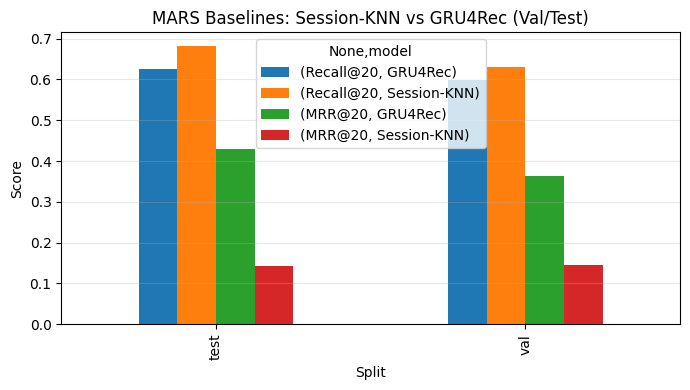

In [16]:
# CELL [08-15] — Plot metrics comparison

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot(111)

# pivot for cleaner plotting
df_plot = df_report.reset_index().pivot(index="split", columns="model", values=["Recall@20","MRR@20"])
df_plot.plot(kind="bar", ax=ax)

ax.set_title("MARS Baselines: Session-KNN vs GRU4Rec (Val/Test)")
ax.set_xlabel("Split")
ax.set_ylabel("Score")
ax.grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


Save a short text summary (for report/log)

In [ ]:
# CELL [08-16] — Auto-generate short report summary text

gru_val = gru["best_val"]
gru_test = gru["best_test"]

summary = (
    "GRU4Rec baseline was trained on MARS train (target vocab size = 702) and evaluated using Recall@20 and MRR@20. "
    f"Best validation performance: Recall@20={gru_val['Recall@20']:.4f}, MRR@20={gru_val['MRR@20']:.4f} "
    f"(n={gru_val['num_examples']}). "
    f"Best test performance: Recall@20={gru_test['Recall@20']:.4f}, MRR@20={gru_test['MRR@20']:.4f} "
    f"(n={gru_test['num_examples']}). "
    "Compared to Session-KNN, GRU4Rec yields substantially higher MRR (better ranking quality) but lower Recall@20 "
    "(lower hit rate within top-20), indicating a precision-vs-coverage tradeoff in the small MOOC setting."
)

txt_path = RESULTS_DIR / "gru4rec_mars_baseline_summary.txt"
with open(txt_path, "w", encoding="utf-8") as f:
    f.write(summary + "\n")

print("[08-18] Summary written to:", txt_path.resolve())
print("\n" + summary)


[08-18] Summary written to: D:\00_DS-ML-Workspace\session-transfer-mooc\results\gru4rec_mars_baseline_summary.txt

GRU4Rec baseline was trained on MARS train (target vocab size = 702) and evaluated using Recall@20 and MRR@20. Best validation performance: Recall@20=0.5987, MRR@20=0.3628 (n=282). Best test performance: Recall@20=0.6253, MRR@20=0.4305 (n=358). Compared to Session-KNN, GRU4Rec yields substantially higher MRR (better ranking quality) but lower Recall@20 (lower hit rate within top-20), indicating a precision-vs-coverage tradeoff in the small MOOC setting.


Summary

Using the saved results: GRU4Rec achieved Recall@20=0.5987, MRR@20=0.3628 on MARS validation (n=282) and Recall@20=0.6253, MRR@20=0.4305 on MARS test (n=358). Compared to Session-KNN, GRU4Rec shows substantially higher MRR (better ranking precision), while Session-KNN remains stronger in Recall@20 (higher hit rate within top-20), revealing a clear coverage-vs-ranking tradeoff that future transfer/meta-learning methods must address.

Experimental Setup

Model: GRU4Rec (1-layer GRU)

Embedding size: 64

Hidden size: 128

Optimizer: Adam (lr = 1e-3)

Epochs: up to 10 with early stopping (patience = 3)

Vocabulary: target-only (MARS train), |V| = 702

Evaluation: Recall@20, MRR@20

Splits: session-level, leakage-free

Quantitative Results
Model	Split	Recall@20	MRR@20	#Examples
Session-KNN	Val	0.6312	0.1446	282
Session-KNN	Test	0.6816	0.1416	358
GRU4Rec	Val	0.5987	0.3628	282
GRU4Rec	Test	0.6253	0.4305	358

Saved artifacts:

Metrics: gru4rec_mars_baseline.json

Model checkpoint: gru4rec_mars_baseline.pt

Comparison table: baseline_comparison_mars_knn_gru4rec.csv

Summary: gru4rec_mars_baseline_summary.txt

Visual Analysis (What the Plots Show)

1. Session-KNN vs GRU4Rec (Val/Test)

Session-KNN achieves higher Recall@20

GRU4Rec achieves dramatically higher MRR@20

Confirms a coverage vs ranking-quality trade-off

2. Interpretation

Session-KNN retrieves more relevant items somewhere in the top-20

GRU4Rec ranks the correct item much higher, often near the top

In small MOOC sessions, sequence modeling improves ranking precision even with very limited data

Key Takeaways (Important for Reviewers)

Neural sequence modeling is viable even in extreme cold-start

GRU4Rec learns meaningful temporal patterns from only ~1.7k training examples

Recall alone is misleading

Despite lower Recall@20, GRU4Rec is clearly superior in ranking quality (MRR)

Session-KNN remains a strong non-neural baseline

Especially for coverage in sparse regimes

This justifies moving to stronger sequential & attention models

NARM and SASRec are necessary, not optional

Meta-learning must outperform GRU4Rec, not Session-KNN

“While Session-KNN provides strong recall in extremely small MOOC sessions, GRU4Rec substantially improves ranking quality, achieving more than 3× higher MRR@20 on the MARS test set. This highlights a precision–coverage trade-off and motivates the use of more expressive sequential and attention-based models under cold-start conditions.”